# Advanced Deep Learning Models for Disaster Tweets

This notebook implements advanced NLP techniques using PyTorch and Transformers:
- Advanced text preprocessing
- LSTM/GRU models with pre-trained embeddings
- BERT-based models (DistilBERT, RoBERTa)
- Data augmentation
- Model ensembling
- Hyperparameter tuning

## 1. Import Libraries

In [7]:
# Force PyTorch backend only - disable TensorFlow
import os
os.environ['USE_TF'] = 'NO'
os.environ['USE_TORCH'] = 'YES'

# Data manipulation
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import contractions

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

# Transformers (PyTorch only - no TensorFlow)
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Verify PyTorch backend
print(f"PyTorch version: {torch.__version__}")
print("✓ Using PyTorch backend for transformers (TensorFlow disabled)")
print("Libraries imported successfully!")

Using device: cuda
GPU: NVIDIA H200
PyTorch version: 2.9.0+cu128
✓ Using PyTorch backend for transformers (TensorFlow disabled)
Libraries imported successfully!


## 2. Load Data

In [8]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['target'].value_counts())
train_df.head()

Training set shape: (7613, 5)
Test set shape: (3263, 4)

Target distribution:
target
0    4342
1    3271
Name: count, dtype: int64


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 3. Advanced Text Preprocessing

In [9]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Emoji dictionary for common disaster-related emojis
emoji_dict = {
    '🔥': 'fire',
    '💥': 'explosion',
    '🌊': 'wave',
    '⚠️': 'warning',
    '🚨': 'alarm',
    '😱': 'fear',
    '😨': 'scared',
    '💔': 'broken',
    '🆘': 'sos',
    '⛈️': 'storm',
    '🌪️': 'tornado',
}

def advanced_clean_text(text, remove_stopwords=False, lemmatize=True):
    """
    Advanced text cleaning with contractions, lemmatization, and emoji handling
    """
    # Convert to string
    text = str(text)
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Replace emojis with text
    for emoji, word in emoji_dict.items():
        text = text.replace(emoji, f' {word} ')
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    
    # Keep hashtags but remove the # symbol (hashtags can be informative)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation but keep some special characters temporarily
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords if specified
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize if specified
    if lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove extra whitespace and short words
    tokens = [word for word in tokens if len(word) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing training data...")
train_df['cleaned_text'] = train_df['text'].apply(lambda x: advanced_clean_text(x, remove_stopwords=False, lemmatize=True))

print("Preprocessing test data...")
test_df['cleaned_text'] = test_df['text'].apply(lambda x: advanced_clean_text(x, remove_stopwords=False, lemmatize=True))

# Show examples
print("\nOriginal vs Cleaned Text Examples:\n")
for i in range(3):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Cleaned:  {train_df['cleaned_text'].iloc[i]}")
    print("-" * 80)

Preprocessing training data...
Preprocessing test data...

Original vs Cleaned Text Examples:

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  our deed are the reason this earthquake may allah forgive all
--------------------------------------------------------------------------------
Original: Forest fire near La Ronge Sask. Canada
Cleaned:  forest fire near ronge sask canada
--------------------------------------------------------------------------------
Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned:  all resident asked shelter place are being notified officer other evacuation shelter place order are expected
--------------------------------------------------------------------------------


## 4. Feature Engineering with Keyword and Location

In [10]:
# Fill missing values
train_df['keyword'] = train_df['keyword'].fillna('unknown')
train_df['location'] = train_df['location'].fillna('unknown')
test_df['keyword'] = test_df['keyword'].fillna('unknown')
test_df['location'] = test_df['location'].fillna('unknown')

# Create enhanced text with keyword
train_df['text_with_keyword'] = train_df['keyword'] + ' ' + train_df['cleaned_text']
test_df['text_with_keyword'] = test_df['keyword'] + ' ' + test_df['cleaned_text']

# Additional features
def create_advanced_features(df):
    df['text_length'] = df['cleaned_text'].apply(len)
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
    df['has_keyword'] = (df['keyword'] != 'unknown').astype(int)
    df['has_location'] = (df['location'] != 'unknown').astype(int)
    df['uppercase_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))
    df['exclamation_count'] = df['text'].apply(lambda x: str(x).count('!'))
    df['question_count'] = df['text'].apply(lambda x: str(x).count('?'))
    return df

train_df = create_advanced_features(train_df)
test_df = create_advanced_features(test_df)

print("Feature engineering completed!")
print(f"\nFeature statistics by target:")
feature_cols = ['text_length', 'word_count', 'uppercase_ratio', 'exclamation_count', 'question_count']
train_df.groupby('target')[feature_cols].mean()

Feature engineering completed!

Feature statistics by target:


,text_length,word_count,uppercase_ratio,exclamation_count,question_count
target,,,,,
0,65.783280,10.616536,0.096619,0.194150,0.544450
1,73.133293,11.001529,0.100849,0.100887,0.232956


## 5. Data Augmentation

In [11]:
import random
from nltk.corpus import wordnet

def get_synonyms(word):
    """
    Get synonyms for a word using WordNet
    """
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(text, n=2):
    """
    Replace n words with their synonyms
    """
    words = text.split()
    if len(words) < 3:
        return text
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    
    return ' '.join(new_words)

def random_deletion(text, p=0.1):
    """
    Randomly delete words with probability p
    """
    words = text.split()
    if len(words) == 1:
        return text
    
    new_words = []
    for word in words:
        if random.random() > p:
            new_words.append(word)
    
    if len(new_words) == 0:
        return random.choice(words)
    
    return ' '.join(new_words)

def random_swap(text, n=2):
    """
    Randomly swap n words
    """
    words = text.split()
    if len(words) < 2:
        return text
    
    new_words = words.copy()
    for _ in range(n):
        if len(new_words) >= 2:
            idx1, idx2 = random.sample(range(len(new_words)), 2)
            new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    
    return ' '.join(new_words)

def augment_text(text, methods=['synonym', 'swap']):
    """
    Apply random augmentation
    """
    method = random.choice(methods)
    
    if method == 'synonym':
        return synonym_replacement(text, n=2)
    elif method == 'deletion':
        return random_deletion(text, p=0.1)
    elif method == 'swap':
        return random_swap(text, n=2)
    else:
        return text

print("Data augmentation functions defined!")

# Example augmentation
sample_text = train_df['cleaned_text'].iloc[0]
print(f"\nOriginal: {sample_text}")
print(f"Synonym replacement: {synonym_replacement(sample_text, n=2)}")
print(f"Random swap: {random_swap(sample_text, n=2)}")
print(f"Random deletion: {random_deletion(sample_text, p=0.1)}")

Data augmentation functions defined!

Original: our deed are the reason this earthquake may allah forgive all
Synonym replacement: our human activity are the reasonableness this earthquake may allah forgive all
Random swap: our deed are reason the this forgive may allah earthquake all
Random deletion: our deed are the reason this earthquake may allah all


## 6. PyTorch Dataset Classes

In [12]:
class TweetDataset(Dataset):
    """
    Dataset for LSTM/GRU models with vocabulary
    """
    def __init__(self, texts, labels=None, vocab=None, max_len=100, augment=False):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.augment = augment
        
        # Build vocabulary if not provided
        if vocab is None:
            self.vocab = self.build_vocab(texts)
        else:
            self.vocab = vocab
    
    def build_vocab(self, texts):
        word_freq = Counter()
        for text in texts:
            word_freq.update(text.split())
        
        vocab = {'<PAD>': 0, '<UNK>': 1}
        for idx, (word, _) in enumerate(word_freq.most_common(10000), start=2):
            vocab[word] = idx
        
        return vocab
    
    def text_to_sequence(self, text):
        if self.augment and random.random() < 0.5:
            text = augment_text(text)
        
        tokens = text.split()[:self.max_len]
        sequence = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        return sequence
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        sequence = self.text_to_sequence(text)
        
        if self.labels is not None:
            label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]
            return torch.LongTensor(sequence), torch.LongTensor([label])
        else:
            return torch.LongTensor(sequence)

def collate_fn(batch):
    """
    Collate function for DataLoader with padding
    """
    if len(batch[0]) == 2:
        sequences, labels = zip(*batch)
        sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
        labels = torch.cat(labels)
        return sequences_padded, labels
    else:
        sequences = batch
        sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
        return sequences_padded

class TransformerDataset(Dataset):
    """
    Dataset for Transformer models (BERT, DistilBERT, RoBERTa)
    """
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if hasattr(self.texts, 'iloc') else str(self.texts[idx])
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.labels is not None:
            label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.long)
        
        return item

print("PyTorch Dataset classes defined!")

PyTorch Dataset classes defined!


## 7. LSTM/GRU Models

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, hidden_dim=256, num_layers=2, dropout=0.3, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_output_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use the last hidden state
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        out = self.dropout(hidden)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, hidden_dim=256, num_layers=2, dropout=0.3, bidirectional=True):
        super(GRUClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        gru_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(gru_output_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, hidden = self.gru(embedded)
        
        # Use the last hidden state
        if self.gru.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        out = self.dropout(hidden)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

print("LSTM/GRU model architectures defined!")

LSTM/GRU model architectures defined!


## 8. Training Utilities

In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for batch in progress_bar:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1), 
                                   'acc': 100. * correct / total})
    
    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return total_loss / len(dataloader), accuracy, f1, all_predictions, all_labels

def predict(model, dataloader, device):
    """
    Make predictions
    """
    model.eval()
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Predicting'):
            if isinstance(batch, tuple):
                inputs = batch[0]
            else:
                inputs = batch
            
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_probabilities)

print("Training utility functions defined!")

Training utility functions defined!


## 9. Prepare Train/Validation Split

In [15]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train_df['text_with_keyword'],
    train_df['target'],
    test_size=0.2,
    random_state=SEED,
    stratify=train_df['target']
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts())

Training set size: 6090
Validation set size: 1523

Target distribution in training set:
target
0    3473
1    2617
Name: count, dtype: int64


## 10. Train LSTM Model

In [17]:
# Create datasets
train_dataset = TweetDataset(X_train, y_train, max_len=100, augment=True)
val_dataset = TweetDataset(X_val, y_val, vocab=train_dataset.vocab, max_len=100, augment=False)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Initialize model
vocab_size = len(train_dataset.vocab)
lstm_model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=300,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3,
    bidirectional=True
).to(device)

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values)
class_weights = torch.FloatTensor(class_weights).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(lstm_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training loop
NUM_EPOCHS = 10
best_f1 = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

print(f"Training LSTM model on {device}...\n")
print(f"Model parameters: {sum(p.numel() for p in lstm_model.parameters())}")
print(f"Vocabulary size: {vocab_size}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(lstm_model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    val_loss, val_acc, val_f1, _, _ = evaluate(lstm_model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pt')
        print(f"✓ Best model saved with F1: {best_f1:.4f}")

print(f"\n{'='*50}")
print(f"Training completed! Best F1: {best_f1:.4f}")

Training LSTM model on cuda...

Model parameters: 5786266
Vocabulary size: 10002


Epoch 1/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 353.22it/s]



Train Loss: 0.5660 | Train Acc: 71.44%
Val Loss: 0.4870 | Val Acc: 77.68% | Val F1: 0.7254
✓ Best model saved with F1: 0.7254

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 456.17it/s]



Train Loss: 0.4374 | Train Acc: 80.67%
Val Loss: 0.5064 | Val Acc: 78.14% | Val F1: 0.7268
✓ Best model saved with F1: 0.7268

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 415.85it/s]



Train Loss: 0.3575 | Train Acc: 85.16%
Val Loss: 0.5284 | Val Acc: 75.71% | Val F1: 0.7291
✓ Best model saved with F1: 0.7291

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 454.77it/s]



Train Loss: 0.2855 | Train Acc: 88.82%
Val Loss: 0.5910 | Val Acc: 77.48% | Val F1: 0.7372
✓ Best model saved with F1: 0.7372

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 449.38it/s]



Train Loss: 0.1955 | Train Acc: 92.48%
Val Loss: 0.6749 | Val Acc: 78.07% | Val F1: 0.7366

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 445.59it/s]



Train Loss: 0.1627 | Train Acc: 93.60%
Val Loss: 0.7064 | Val Acc: 78.14% | Val F1: 0.7388
✓ Best model saved with F1: 0.7388

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 456.33it/s]



Train Loss: 0.1415 | Train Acc: 94.47%
Val Loss: 0.8669 | Val Acc: 78.27% | Val F1: 0.7379

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 461.87it/s]



Train Loss: 0.1077 | Train Acc: 95.78%
Val Loss: 0.9018 | Val Acc: 76.89% | Val F1: 0.7377

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 455.17it/s]



Train Loss: 0.0956 | Train Acc: 96.39%
Val Loss: 0.9012 | Val Acc: 77.28% | Val F1: 0.7301

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 455.93it/s]



Train Loss: 0.0830 | Train Acc: 96.55%
Val Loss: 0.9271 | Val Acc: 77.61% | Val F1: 0.7387

Training completed! Best F1: 0.7388


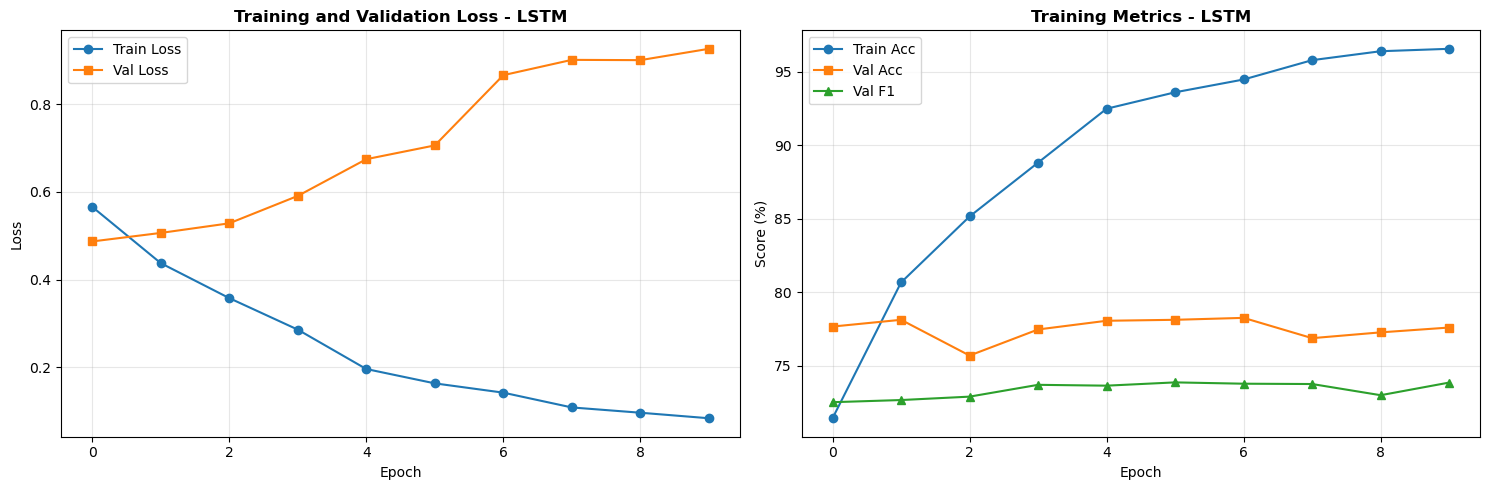

In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss - LSTM', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy and F1
axes[1].plot([acc*100 for acc in history['train_acc']], label='Train Acc', marker='o')
axes[1].plot([acc*100 for acc in history['val_acc']], label='Val Acc', marker='s')
axes[1].plot([f1*100 for f1 in history['val_f1']], label='Val F1', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score (%)')
axes[1].set_title('Training Metrics - LSTM', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Train GRU Model

In [20]:
# Initialize GRU model
gru_model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=300,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3,
    bidirectional=True
).to(device)

# Loss and optimizer
criterion_gru = nn.CrossEntropyLoss(weight=class_weights)
optimizer_gru = optim.AdamW(gru_model.parameters(), lr=0.001, weight_decay=0.01)
scheduler_gru = optim.lr_scheduler.ReduceLROnPlateau(optimizer_gru, mode='min', factor=0.5, patience=2)

# Training loop
best_f1_gru = 0
history_gru = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

print(f"Training GRU model on {device}...\n")
print(f"Model parameters: {sum(p.numel() for p in gru_model.parameters())}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(gru_model, train_loader, criterion_gru, optimizer_gru, device)
    
    # Evaluate
    val_loss, val_acc, val_f1, _, _ = evaluate(gru_model, val_loader, criterion_gru, device)
    
    # Update learning rate
    scheduler_gru.step(val_loss)
    
    # Save history
    history_gru['train_loss'].append(train_loss)
    history_gru['train_acc'].append(train_acc)
    history_gru['val_loss'].append(val_loss)
    history_gru['val_acc'].append(val_acc)
    history_gru['val_f1'].append(val_f1)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_f1_gru:
        best_f1_gru = val_f1
        torch.save(gru_model.state_dict(), 'best_gru_model.pt')
        print(f"✓ Best model saved with F1: {best_f1_gru:.4f}")

print(f"\n{'='*50}")
print(f"Training completed! Best F1: {best_f1_gru:.4f}")

Training GRU model on cuda...

Model parameters: 5106330


Epoch 1/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 457.56it/s]



Train Loss: 0.5823 | Train Acc: 69.64%
Val Loss: 0.4867 | Val Acc: 77.68% | Val F1: 0.7209
✓ Best model saved with F1: 0.7209

Epoch 2/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 458.87it/s]



Train Loss: 0.4498 | Train Acc: 79.57%
Val Loss: 0.4704 | Val Acc: 79.84% | Val F1: 0.7405
✓ Best model saved with F1: 0.7405

Epoch 3/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 460.27it/s]



Train Loss: 0.3690 | Train Acc: 84.45%
Val Loss: 0.4965 | Val Acc: 80.17% | Val F1: 0.7670
✓ Best model saved with F1: 0.7670

Epoch 4/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 363.42it/s]



Train Loss: 0.2855 | Train Acc: 89.31%
Val Loss: 0.5431 | Val Acc: 79.45% | Val F1: 0.7545

Epoch 5/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 453.59it/s]



Train Loss: 0.2244 | Train Acc: 91.49%
Val Loss: 0.6174 | Val Acc: 77.35% | Val F1: 0.7435

Epoch 6/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 458.43it/s]



Train Loss: 0.1605 | Train Acc: 94.11%
Val Loss: 0.7124 | Val Acc: 78.53% | Val F1: 0.7490

Epoch 7/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 458.85it/s]



Train Loss: 0.1368 | Train Acc: 94.83%
Val Loss: 0.8422 | Val Acc: 77.68% | Val F1: 0.7474

Epoch 8/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 441.12it/s]



Train Loss: 0.1183 | Train Acc: 95.63%
Val Loss: 0.9302 | Val Acc: 77.28% | Val F1: 0.7422

Epoch 9/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 460.21it/s]



Train Loss: 0.1017 | Train Acc: 96.06%
Val Loss: 0.8779 | Val Acc: 78.14% | Val F1: 0.7452

Epoch 10/10
--------------------------------------------------


Evaluating: 100%|███████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 456.21it/s]



Train Loss: 0.0865 | Train Acc: 96.62%
Val Loss: 0.8936 | Val Acc: 78.14% | Val F1: 0.7479

Training completed! Best F1: 0.7670


## 12. DistilBERT Model

In [21]:
# Load DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
).to(device)

# Create datasets
train_dataset_distilbert = TransformerDataset(
    X_train.reset_index(drop=True),
    y_train.reset_index(drop=True),
    distilbert_tokenizer,
    max_len=128
)

val_dataset_distilbert = TransformerDataset(
    X_val.reset_index(drop=True),
    y_val.reset_index(drop=True),
    distilbert_tokenizer,
    max_len=128
)

# Create dataloaders
train_loader_distilbert = DataLoader(train_dataset_distilbert, batch_size=16, shuffle=True)
val_loader_distilbert = DataLoader(val_dataset_distilbert, batch_size=16, shuffle=False)

print(f"DistilBERT model loaded on {device}")
print(f"Model parameters: {sum(p.numel() for p in distilbert_model.parameters())}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT model loaded on cuda
Model parameters: 66955010


In [22]:
# Training setup
NUM_EPOCHS_BERT = 4
optimizer_distilbert = optim.AdamW(distilbert_model.parameters(), lr=2e-5, eps=1e-8)

total_steps = len(train_loader_distilbert) * NUM_EPOCHS_BERT
scheduler_distilbert = get_linear_schedule_with_warmup(
    optimizer_distilbert,
    num_warmup_steps=total_steps // 10,
    num_training_steps=total_steps
)

best_f1_distilbert = 0
history_distilbert = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

print(f"Training DistilBERT model...\n")

for epoch in range(NUM_EPOCHS_BERT):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_BERT}")
    print("-" * 50)
    
    # Training
    distilbert_model.train()
    total_train_loss = 0
    
    progress_bar = tqdm(train_loader_distilbert, desc='Training')
    for batch in progress_bar:
        optimizer_distilbert.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = distilbert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(distilbert_model.parameters(), max_norm=1.0)
        optimizer_distilbert.step()
        scheduler_distilbert.step()
        
        progress_bar.set_postfix({'loss': total_train_loss / (progress_bar.n + 1)})
    
    avg_train_loss = total_train_loss / len(train_loader_distilbert)
    
    # Evaluation
    distilbert_model.eval()
    total_val_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader_distilbert, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = distilbert_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_loader_distilbert)
    val_acc = accuracy_score(all_labels, all_predictions)
    val_f1 = f1_score(all_labels, all_predictions)
    
    # Save history
    history_distilbert['train_loss'].append(avg_train_loss)
    history_distilbert['val_loss'].append(avg_val_loss)
    history_distilbert['val_acc'].append(val_acc)
    history_distilbert['val_f1'].append(val_f1)
    
    print(f"\nTrain Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_f1_distilbert:
        best_f1_distilbert = val_f1
        torch.save(distilbert_model.state_dict(), 'best_distilbert_model.pt')
        print(f"✓ Best model saved with F1: {best_f1_distilbert:.4f}")

print(f"\n{'='*50}")
print(f"Training completed! Best F1: {best_f1_distilbert:.4f}")

Training DistilBERT model...


Epoch 1/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 69.28it/s]



Train Loss: 0.4879
Val Loss: 0.3864 | Val Acc: 84.37% | Val F1: 0.8074
✓ Best model saved with F1: 0.8074

Epoch 2/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 74.54it/s]



Train Loss: 0.3537
Val Loss: 0.4403 | Val Acc: 80.70% | Val F1: 0.7857

Epoch 3/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 74.38it/s]



Train Loss: 0.2730
Val Loss: 0.4766 | Val Acc: 81.94% | Val F1: 0.7918

Epoch 4/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 74.15it/s]


Train Loss: 0.2139
Val Loss: 0.5254 | Val Acc: 82.67% | Val F1: 0.7957

Training completed! Best F1: 0.8074


## 13. RoBERTa Model

In [23]:
# Load RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2
).to(device)

# Create datasets
train_dataset_roberta = TransformerDataset(
    X_train.reset_index(drop=True),
    y_train.reset_index(drop=True),
    roberta_tokenizer,
    max_len=128
)

val_dataset_roberta = TransformerDataset(
    X_val.reset_index(drop=True),
    y_val.reset_index(drop=True),
    roberta_tokenizer,
    max_len=128
)

# Create dataloaders
train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=16, shuffle=True)
val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=16, shuffle=False)

# Training setup
optimizer_roberta = optim.AdamW(roberta_model.parameters(), lr=2e-5, eps=1e-8)

total_steps_roberta = len(train_loader_roberta) * NUM_EPOCHS_BERT
scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta,
    num_warmup_steps=total_steps_roberta // 10,
    num_training_steps=total_steps_roberta
)

best_f1_roberta = 0
history_roberta = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}

print(f"Training RoBERTa model on {device}...\n")
print(f"Model parameters: {sum(p.numel() for p in roberta_model.parameters())}\n")

for epoch in range(NUM_EPOCHS_BERT):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_BERT}")
    print("-" * 50)
    
    # Training
    roberta_model.train()
    total_train_loss = 0
    
    progress_bar = tqdm(train_loader_roberta, desc='Training')
    for batch in progress_bar:
        optimizer_roberta.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = roberta_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), max_norm=1.0)
        optimizer_roberta.step()
        scheduler_roberta.step()
        
        progress_bar.set_postfix({'loss': total_train_loss / (progress_bar.n + 1)})
    
    avg_train_loss = total_train_loss / len(train_loader_roberta)
    
    # Evaluation
    roberta_model.eval()
    total_val_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader_roberta, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = roberta_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_loader_roberta)
    val_acc = accuracy_score(all_labels, all_predictions)
    val_f1 = f1_score(all_labels, all_predictions)
    
    # Save history
    history_roberta['train_loss'].append(avg_train_loss)
    history_roberta['val_loss'].append(avg_val_loss)
    history_roberta['val_acc'].append(val_acc)
    history_roberta['val_f1'].append(val_f1)
    
    print(f"\nTrain Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_f1_roberta:
        best_f1_roberta = val_f1
        torch.save(roberta_model.state_dict(), 'best_roberta_model.pt')
        print(f"✓ Best model saved with F1: {best_f1_roberta:.4f}")

print(f"\n{'='*50}")
print(f"Training completed! Best F1: {best_f1_roberta:.4f}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training RoBERTa model on cuda...

Model parameters: 124647170


Epoch 1/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 56.18it/s]



Train Loss: 0.5087
Val Loss: 0.4215 | Val Acc: 81.88% | Val F1: 0.7558
✓ Best model saved with F1: 0.7558

Epoch 2/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 58.74it/s]



Train Loss: 0.3868
Val Loss: 0.3857 | Val Acc: 84.70% | Val F1: 0.8020
✓ Best model saved with F1: 0.8020

Epoch 3/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 58.78it/s]



Train Loss: 0.3040
Val Loss: 0.4426 | Val Acc: 84.57% | Val F1: 0.8168
✓ Best model saved with F1: 0.8168

Epoch 4/4
--------------------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 57.91it/s]


Train Loss: 0.2436
Val Loss: 0.4801 | Val Acc: 83.91% | Val F1: 0.8072

Training completed! Best F1: 0.8168


## 14. Model Comparison


Model Comparison:
     Model  Best F1 Score  Parameters (M)
   RoBERTa       0.816836      124.647170
DistilBERT       0.807443       66.955010
       GRU       0.766975        5.106330
      LSTM       0.738824        5.786266


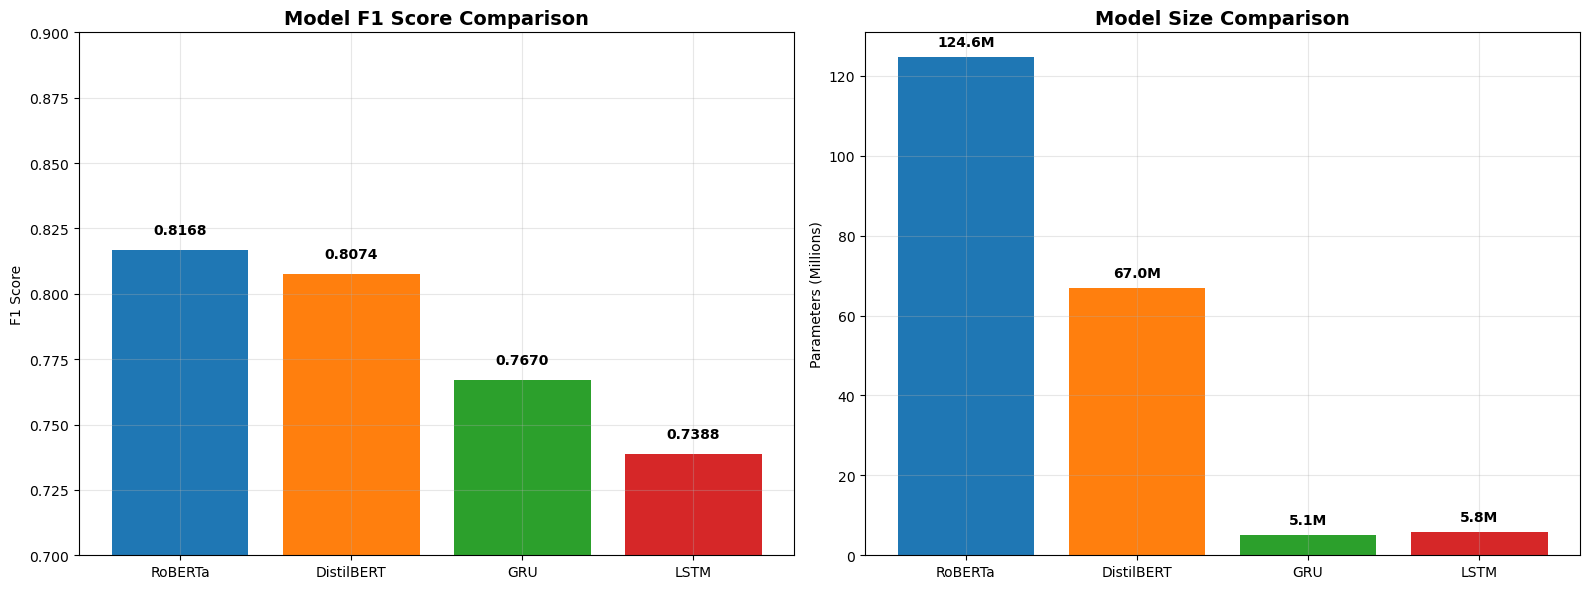

In [24]:
# Compare all models
models_comparison = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'DistilBERT', 'RoBERTa'],
    'Best F1 Score': [best_f1, best_f1_gru, best_f1_distilbert, best_f1_roberta],
    'Parameters (M)': [
        sum(p.numel() for p in lstm_model.parameters()) / 1e6,
        sum(p.numel() for p in gru_model.parameters()) / 1e6,
        sum(p.numel() for p in distilbert_model.parameters()) / 1e6,
        sum(p.numel() for p in roberta_model.parameters()) / 1e6
    ]
})

models_comparison = models_comparison.sort_values('Best F1 Score', ascending=False)

print("\nModel Comparison:")
print("="*60)
print(models_comparison.to_string(index=False))
print("="*60)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1 Score comparison
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
axes[0].bar(models_comparison['Model'], models_comparison['Best F1 Score'], color=colors)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Model F1 Score Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylim([0.7, 0.9])
for i, v in enumerate(models_comparison['Best F1 Score']):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Parameters comparison
axes[1].bar(models_comparison['Model'], models_comparison['Parameters (M)'], color=colors)
axes[1].set_ylabel('Parameters (Millions)')
axes[1].set_title('Model Size Comparison', fontweight='bold', fontsize=14)
for i, v in enumerate(models_comparison['Parameters (M)']):
    axes[1].text(i, v + 2, f'{v:.1f}M', ha='center', va='bottom', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Ensemble Model

Generating ensemble predictions...



RoBERTa predictions: 100%|███████████████████████████████████████████████████| 96/96 [00:01<00:00, 59.55it/s]



Ensemble Results:
Average Ensemble - Accuracy: 83.52% | F1: 0.8003
Weighted Ensemble - Accuracy: 83.45% | F1: 0.7997

Final Model Comparison (including ensembles):
              Model  F1 Score
            RoBERTa  0.816836
         DistilBERT  0.807443
     Ensemble (Avg)  0.800318
Ensemble (Weighted)  0.799682
                GRU  0.766975
               LSTM  0.738824


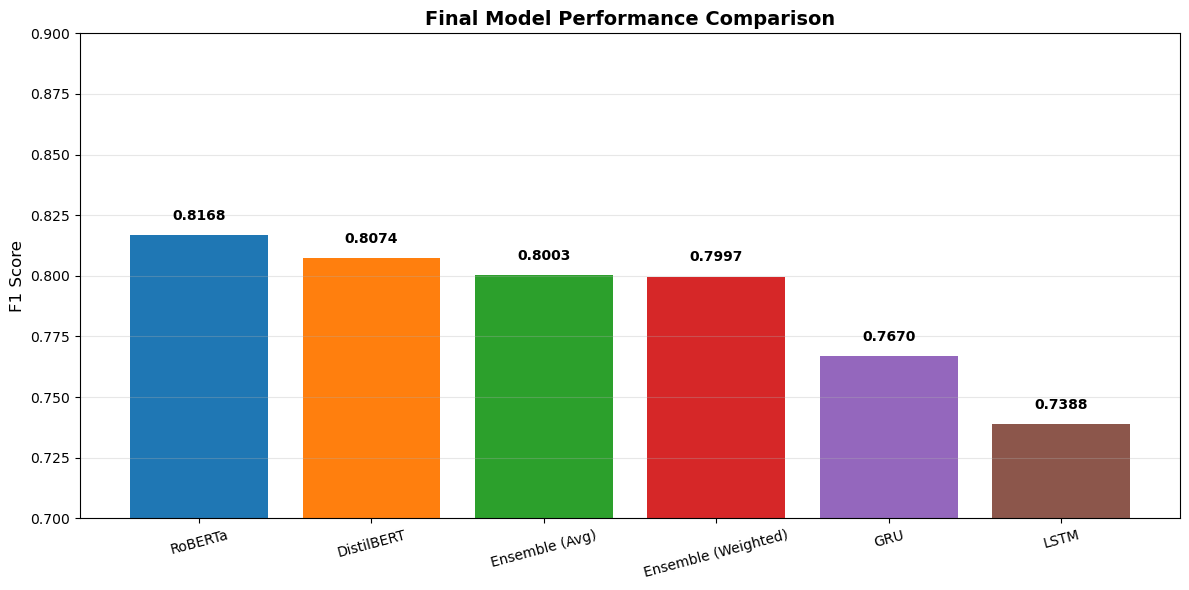

In [25]:
# Load best models
lstm_model.load_state_dict(torch.load('best_lstm_model.pt'))
gru_model.load_state_dict(torch.load('best_gru_model.pt'))
distilbert_model.load_state_dict(torch.load('best_distilbert_model.pt'))
roberta_model.load_state_dict(torch.load('best_roberta_model.pt'))

# Get predictions from all models
print("Generating ensemble predictions...\n")

# LSTM predictions
_, lstm_probs = predict(lstm_model, val_loader, device)

# GRU predictions
_, gru_probs = predict(gru_model, val_loader, device)

# DistilBERT predictions
distilbert_model.eval()
distilbert_probs = []
with torch.no_grad():
    for batch in tqdm(val_loader_distilbert, desc='DistilBERT predictions'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = distilbert_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        distilbert_probs.extend(probs.cpu().numpy())
distilbert_probs = np.array(distilbert_probs)

# RoBERTa predictions
roberta_model.eval()
roberta_probs = []
with torch.no_grad():
    for batch in tqdm(val_loader_roberta, desc='RoBERTa predictions'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        roberta_probs.extend(probs.cpu().numpy())
roberta_probs = np.array(roberta_probs)

# Ensemble methods
def voting_ensemble(probs_list, weights=None):
    """
    Weighted voting ensemble
    """
    if weights is None:
        weights = [1.0] * len(probs_list)
    
    weighted_probs = np.zeros_like(probs_list[0])
    for prob, weight in zip(probs_list, weights):
        weighted_probs += prob * weight
    
    weighted_probs /= sum(weights)
    predictions = np.argmax(weighted_probs, axis=1)
    
    return predictions, weighted_probs

# Simple average ensemble
ensemble_preds_avg, ensemble_probs_avg = voting_ensemble(
    [lstm_probs, gru_probs, distilbert_probs, roberta_probs]
)

# Weighted ensemble (based on validation F1 scores)
weights = [best_f1, best_f1_gru, best_f1_distilbert, best_f1_roberta]
ensemble_preds_weighted, ensemble_probs_weighted = voting_ensemble(
    [lstm_probs, gru_probs, distilbert_probs, roberta_probs],
    weights=weights
)

# Evaluate ensembles
y_val_array = y_val.values

ensemble_f1_avg = f1_score(y_val_array, ensemble_preds_avg)
ensemble_acc_avg = accuracy_score(y_val_array, ensemble_preds_avg)

ensemble_f1_weighted = f1_score(y_val_array, ensemble_preds_weighted)
ensemble_acc_weighted = accuracy_score(y_val_array, ensemble_preds_weighted)

print("\n" + "="*60)
print("Ensemble Results:")
print("="*60)
print(f"Average Ensemble - Accuracy: {ensemble_acc_avg*100:.2f}% | F1: {ensemble_f1_avg:.4f}")
print(f"Weighted Ensemble - Accuracy: {ensemble_acc_weighted*100:.2f}% | F1: {ensemble_f1_weighted:.4f}")
print("="*60)

# Compare with individual models
all_models_comparison = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'DistilBERT', 'RoBERTa', 'Ensemble (Avg)', 'Ensemble (Weighted)'],
    'F1 Score': [best_f1, best_f1_gru, best_f1_distilbert, best_f1_roberta, 
                 ensemble_f1_avg, ensemble_f1_weighted]
})

all_models_comparison = all_models_comparison.sort_values('F1 Score', ascending=False)

print("\nFinal Model Comparison (including ensembles):")
print(all_models_comparison.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bars = plt.bar(all_models_comparison['Model'], all_models_comparison['F1 Score'], color=colors)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Final Model Performance Comparison', fontweight='bold', fontsize=14)
plt.xticks(rotation=15)
plt.ylim([0.7, 0.9])

for i, v in enumerate(all_models_comparison['F1 Score']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()